<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRA1: Deep Reinforcement Learning

#### AUTOR: Mario Ubierna San Mamés
 

En esta práctica se hará un estudio sobre el entorno **highway-env**, donde inicialmente se realizará una exploración sobre el entorno, posteriormente implementaremos un agente DQN y finalmente mejoraremos el primer agente implementado

## 0. Contexto

**Highway-env** es un problema de conducción autónoma, donde tenemos múltiples carriles y varios coches transitando. Nuestro objetivo es que el agente sea capaz de controlar el vehículo con el fin de:

- Evitar colisiones con otros vehículos.
- Tener la máxima velocidad posible.
- Mantenerse en el carril derecho lo más posible.

El entorno se considera superado cuando en el tiempo de observación máximo establecido, se han verificado las tres condiciones anteriores.

![Alt Text](https://raw.githubusercontent.com/eleurent/highway-env/gh-media/docs/media/highway-env.gif?raw=true)

## 1. Entorno

Lo primero de todo es cargar las librerías necesarias:

In [1]:
import gym
import highway_env
from collections import namedtuple, deque
from copy import deepcopy, copy
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
import time

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.1 (0.5 ptos) - </strong> Exploración del entorno y representación de una ejecución aleatoria:
</div>

#### Exploración del entorno

Carga del entorno:

In [2]:
# Definimos el entorno
env = gym.make("highway-v0")

Información básica del entorno:

In [3]:
print("El espacio de acciones es {} ".format(env.action_space))
print("La dimensión del espacio de acciones es: {}".format(env.action_space.n))
# print("Las acciones por defecto son {}".format(str(env.action_type.actions_indexes)))
print("El espacio de observaciones es {} ".format(env.observation_space))
print("La dimensión del espacio de estados: {}".format(env.observation_space.shape[0]))
print("El rango de recompensas es {} ".format(env.reward_range))

El espacio de acciones es Discrete(5) 
La dimensión del espacio de acciones es: 5
El espacio de observaciones es Box([[-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]], [[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]], (5, 5), float32) 
La dimensión del espacio de estados: 5
El rango de recompensas es (-inf, inf) 


De la anterior ejecución podemos observar que, por defecto tanto la dimensión del espacio de acciones como de estados es 5. Estos valores vienen predefinidos a la hora de cargar el entorno **highway-v0**.  
  
Para saber más sobre la configuración por defecto del entorno ejecutamos la siguiente instrucción:

In [4]:
env.env.default_config()

{'observation': {'type': 'Kinematics'},
 'action': {'type': 'DiscreteMetaAction'},
 'simulation_frequency': 15,
 'policy_frequency': 1,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 150,
 'centering_position': [0.3, 0.5],
 'scaling': 5.5,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'lanes_count': 4,
 'vehicles_count': 50,
 'controlled_vehicles': 1,
 'initial_lane_id': None,
 'duration': 40,
 'ego_spacing': 2,
 'vehicles_density': 1,
 'collision_reward': -1,
 'right_lane_reward': 0.1,
 'high_speed_reward': 0.4,
 'lane_change_reward': 0,
 'reward_speed_range': [20, 30],
 'offroad_terminal': False}

Como podemos ver obtenemos la siguiente información:  
- El tipo de observación es Kinematics, esto lo que significa es que el espacio de estados va a ser una matriz del tipo VxF, donde V es el número de vehículos cercanos a nuestro coche y F el número de características (['presence', 'x', 'y', 'vx', 'vy']).

- El tipo de acciones es DiscreteMetaAction, en este caso hay 5 acciones. La primera es movernos al carril de la izquierda "0", la segunda es un movimiento ilegal o mantenernos en el carril actual a la velocidad actual "1" (cuando se produce un cambio de carril en el límite de la carretera, o cuando la acelaración o desaceleración es mayor o menor que la velocidad máxima/mínima) "1", la tercera es movernos al carril de la derecha "2", la cuarta es aumentar la velocidad "3" y la quinta reducir la velocidad "4".

- El número de carriles es 4, se puede modificar para añadir más o menos.

- El número de vehículos es 50 y al igual que antes se puede modificar.

- La recompensa por colisión es -1.

- La recompensa por estar en el carril de la derecha es 0.1.

- La recompensa por alcanzar una alta velocidad es 0.4.

- La recompensa por cambiar de carril es 0.

- Y la recompensa por aumentar o disminuir la velocidad varía entre 20 y 30 dependiendo de forma lineal a su velocidad.

A continuación podemos ver un ejemplo de una acción tomada aleatoriamente y todas las posibles acciones que podemos tomar:

In [5]:
print("Acción aleatoria tomada {}".format(env.action_space.sample()))
print("Las posibles acciones son {}".format(env.action_type.actions_indexes))

Acción aleatoria tomada 3
Las posibles acciones son {'LANE_LEFT': 0, 'IDLE': 1, 'LANE_RIGHT': 2, 'FASTER': 3, 'SLOWER': 4}


Para concluir con la exploración del entorno, vamos a mostrar un ejemplo de un estado según el espacio de observaciones por defecto junto el nombre de cada columna:

In [6]:
print("Un estado aleatorio sería \n{}".format(env.observation_space.sample()))
print("El nombre de cada columna (característica \"F\") es {}".format(env.env.observation_type.features))

Un estado aleatorio sería 
[[ 0.14268285  1.2118269  -0.34587082 -0.06190427  0.33943194]
 [ 0.2505384  -1.6711683  -1.4763973   0.12785144 -0.5120285 ]
 [ 0.42212814 -0.5311321   0.87659407  1.2611146   0.00489002]
 [ 0.7085938   1.6524698  -0.16423865  0.32951674 -0.9380827 ]
 [ 0.7669441  -0.06417153  0.32141888  0.703006    0.97763485]]
El nombre de cada columna (característica "F") es ['presence', 'x', 'y', 'vx', 'vy']


#### Representación de una ejecución aleatoria

Obs inicial:


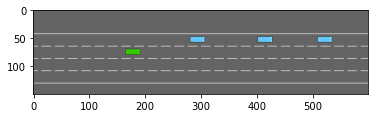

[[ 1.          0.907227    0.25        0.3125      0.        ]
 [ 1.          0.10510522 -0.25       -0.02823919  0.        ]
 [ 1.          0.21496983 -0.25       -0.03506956  0.        ]
 [ 1.          0.31259692 -0.25       -0.04603598  0.        ]
 [ 1.          0.41965762  0.         -0.02470521  0.        ]]

Acción: SLOWER -> recommpensa: 0.7116739868390409
Nuevo estado:


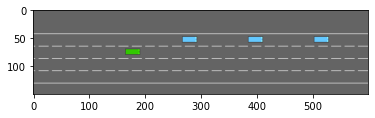

[[ 1.          1.          0.25        0.26068053  0.        ]
 [ 1.          0.09237286 -0.25       -0.05141971  0.        ]
 [ 1.          0.19985215 -0.25       -0.04942344  0.        ]
 [ 1.          0.3063824  -0.25        0.00369388  0.        ]
 [ 1.          0.4211148   0.          0.01676722  0.        ]]

Acción: LANE_RIGHT -> recommpensa: 0.7150048162755963
Nuevo estado:


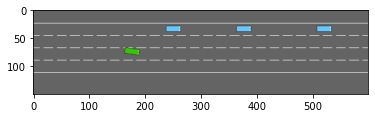

[[ 1.          1.          0.4575555   0.24963844  0.03311444]
 [ 1.          0.06592519 -0.4575555  -0.08100125 -0.03311444]
 [ 1.          0.18014537 -0.4575555  -0.05179527 -0.03311444]
 [ 1.          0.31098515 -0.4575555   0.01296245 -0.03311444]
 [ 1.          0.42924777 -0.2075555   0.01759887 -0.03311444]]

Acción: LANE_LEFT -> recommpensa: 0.6895542772906024
Nuevo estado:


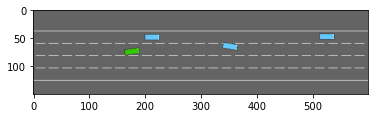

[[ 1.          1.          0.30211458  0.24822603 -0.03224728]
 [ 1.          0.03148612 -0.29245567 -0.08479107  0.02895433]
 [ 1.          0.15842217 -0.09168241 -0.04529034  0.0650113 ]
 [ 1.          0.3162589  -0.30211458  0.01160545  0.03224728]
 [ 1.          0.4354944  -0.05211457  0.0132008   0.03224728]]

Acción: SLOWER -> recommpensa: 0.6890025959381983
Nuevo estado:


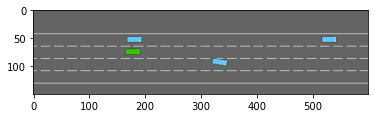

[[ 1.          1.          0.24106829  0.25004375 -0.00218603]
 [ 1.          0.00218518 -0.24105255 -0.05962305  0.00123909]
 [ 1.          0.14139399  0.22056024 -0.03047924  0.03961857]
 [ 1.          0.31957036 -0.24106829  0.00633473  0.00218603]
 [ 1.          0.44091615  0.00893171  0.01625187  0.00218603]]

Acción: SLOWER -> recommpensa: 0.6889083200858099
Nuevo estado:


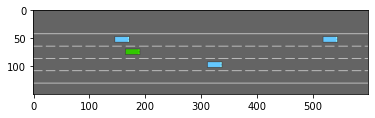

[[ 1.          1.          0.24728775  0.25000453  0.00151279]
 [ 1.         -0.01746958 -0.24774656 -0.03818986 -0.00140225]
 [ 1.          0.13319214  0.26642555 -0.0127471  -0.0015546 ]
 [ 1.          0.321772   -0.24728775  0.00477001 -0.00151279]
 [ 1.          0.44819245  0.00271225  0.02000184 -0.00151279]]

Acción: LANE_RIGHT -> recommpensa: 0.7111144316740498
Nuevo estado:


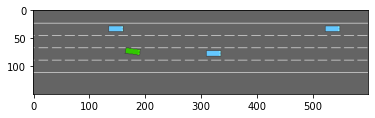

[[ 1.0000000e+00  1.0000000e+00  4.5910123e-01  2.4778135e-01
   3.3244208e-02]
 [ 1.0000000e+00 -2.8135983e-02 -4.5911771e-01 -2.0215949e-02
  -3.3197712e-02]
 [ 1.0000000e+00  1.3151909e-01  4.3125644e-02 -9.0951280e-04
  -3.5073455e-02]
 [ 1.0000000e+00  3.2502607e-01 -4.5910123e-01  6.3415468e-03
  -3.3244208e-02]
 [ 1.0000000e+00  4.5808566e-01 -2.0910122e-01  2.4123549e-02
  -3.3244208e-02]]

Acción: SLOWER -> recommpensa: 0.7111116785562497
Nuevo estado:


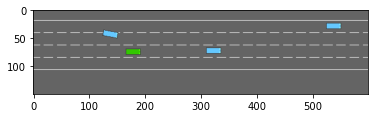

[[ 1.0000000e+00  1.0000000e+00  5.1138484e-01  2.4999967e-01
   5.4464181e-04]
 [ 1.0000000e+00 -3.6087390e-02 -3.4746563e-01 -1.5347900e-02
   4.4415161e-02]
 [ 1.0000000e+00  1.3163052e-01 -1.2026751e-02  2.8493705e-03
  -5.7226431e-04]
 [ 1.0000000e+00  3.2678348e-01 -5.1138484e-01  3.9797416e-03
  -5.4464181e-04]
 [ 1.0000000e+00  4.6716848e-01 -2.6138481e-01  2.2700228e-02
  -5.4464181e-04]]

Acción: IDLE -> recommpensa: 0.711111208080809
Nuevo estado:


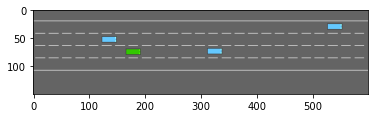

[[ 1.0000000e+00  1.0000000e+00  5.0222445e-01  2.4999493e-01
  -1.5977166e-03]
 [ 1.0000000e+00 -3.8638361e-02 -2.4150392e-01  4.5036149e-04
   6.5957890e-03]
 [ 1.0000000e+00  1.3349605e-01 -2.3473077e-03  6.3864128e-03
   1.6878478e-03]
 [ 1.0000000e+00  3.2839161e-01 -5.0222445e-01  4.0859464e-03
   1.5977166e-03]
 [ 1.0000000e+00  4.7631058e-01 -2.5222448e-01  2.2965161e-02
   1.5977166e-03]]

Acción: LANE_LEFT -> recommpensa: 0.6888889054598694
Nuevo estado:


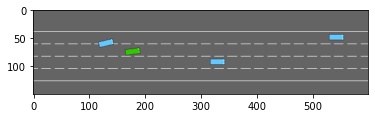

[[ 1.          1.          0.29077682  0.24778993 -0.03316855]
 [ 1.         -0.04314264 -0.16612223 -0.0495937  -0.0128296 ]
 [ 1.          0.1379476   0.20925301  0.01059772  0.03317138]
 [ 1.          0.33154678 -0.29077682  0.00650219  0.03316855]
 [ 1.          0.4869943  -0.04077682  0.02522668  0.03316855]]

Acción: FASTER -> recommpensa: 0.7994371271038557
Nuevo estado:


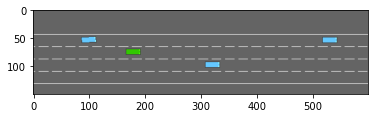

[[ 1.0000000e+00  1.0000000e+00  2.3484851e-01  3.0181947e-01
  -3.3699191e-05]
 [ 1.0000000e+00  1.2912045e-01  2.6515809e-01 -4.2342108e-02
   2.9272771e-05]
 [ 1.0000000e+00  3.2090148e-01 -2.3484851e-01 -4.7275268e-02
   3.3699191e-05]
 [ 1.0000000e+00  4.8379317e-01  1.5151479e-02 -2.8801661e-02
   3.3699191e-05]
 [ 1.0000000e+00  5.0363010e-01  5.1515150e-01 -5.7029668e-02
   3.3699191e-05]]

Acción: IDLE -> recommpensa: 0.8183285175416559
Nuevo estado:


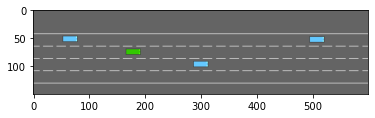

[[ 1.          1.          0.24746904  0.31066787  0.00207775]
 [ 1.          0.1101576   0.2525296  -0.05063698 -0.00207797]
 [ 1.          0.29989716 -0.24746904 -0.05586502 -0.00207775]
 [ 1.          0.47012922  0.00253096 -0.03765293 -0.00207775]
 [ 1.          0.47875896  0.50253093 -0.06542303 -0.00207775]]

Acción: FASTER -> recommpensa: 0.9321050692863859
Nuevo estado:


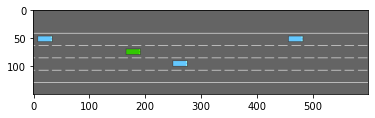

[[ 1.00000000e+00  1.00000000e+00  2.51042694e-01  3.64007592e-01
  -3.85300991e-05]
 [ 1.00000000e+00  7.70237520e-02  2.48956963e-01 -1.03731126e-01
   3.87461732e-05]
 [ 1.00000000e+00  2.64665663e-01 -2.51042694e-01 -1.08955696e-01
   3.85300991e-05]
 [ 1.00000000e+00  4.39748168e-01  4.98957306e-01 -1.18271433e-01
   3.85300991e-05]
 [ 1.00000000e+00  4.42135692e-01 -1.04268582e-03 -9.09918845e-02
   3.85300991e-05]]

Acción: LANE_RIGHT -> recommpensa: 0.9737703655781148
Nuevo estado:


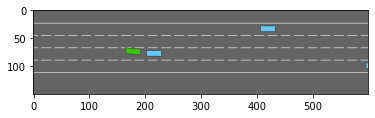

[[ 1.          1.          0.4589509   0.3715167   0.03456888]
 [ 1.          0.03432272  0.04104916 -0.11116873 -0.03456887]
 [ 1.          0.21990123 -0.4589509  -0.11623222 -0.03456888]
 [ 1.          0.39130792  0.2910491  -0.12527266 -0.03456888]
 [ 1.          0.40451258 -0.2089509  -0.09850334 -0.03456888]]

Acción: LANE_LEFT -> recommpensa: 0.022222222222222216
Nuevo estado:


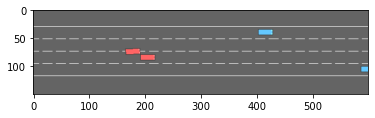

[[ 1.          1.          0.38884607  0.17476429 -0.0093665 ]
 [ 1.          0.02381343  0.11984346 -0.05287667  0.0093665 ]
 [ 1.          0.2156178  -0.38884607  0.08073432  0.0093665 ]
 [ 1.          0.3834633   0.36115393  0.07199144  0.0093665 ]
 [ 1.          0.4072781  -0.13884605  0.09823571  0.0093665 ]]
Episodio terminado después de 14 pasos y la recompensa fue 9.862233521932461


In [7]:
obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial:")
plt.imshow(env.render(mode="rgb_array"))
plt.show()
print(obs)

while not done:
    # Obtener la acción y la ejecutamos
    action = env.action_space.sample()
    new_obs, reward, done, info = env.step(action)
    
    # Imprimimos el paso
    print("\nAcción: {} -> recommpensa: {}".format(env.action_type.actions[action], reward))
    print("Nuevo estado:")
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
    env.close()
    print(new_obs)
    
    t += 1
    total_reward += reward
    obs = new_obs
    
print("Episodio terminado después de {} pasos y la recompensa fue {}".format(t, total_reward))

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.2 (0.5 ptos) - </strong> Explicar los diferentes espacios de observaciones y de acciones:
</div>

Resuelto en el informe

## 2. Agente de referencia

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.1 (1.5 ptos) - </strong> Implementar un agente DQN con la observación kinematics
</div>

Lo primero de todo es definir la clase que nos va a permitir crear el replay buffer:

In [8]:
class experienceReplayBuffer:

    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer', 
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size, 
                                   replace=False)
        # Use asterisk operator to unpack deque 
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

Posteriormente tenemos que crear la red neuronal:

In [9]:
class NeuralNet(torch.nn.Module):  

    def __init__(self, env, learning_rate=1e-3):
        
        """
        Params
        ======
        n_inputs: tamaño del espacio de estadps
        n_outputs: tamaño del espacio de acciones
        actions: array de acciones posibles
        """
        ######################################
        ##TODO: Inicializar parámetros
        super(NeuralNet, self).__init__()
        self.n_inputs = env.observation_space.shape[0] * env.observation_space.shape[1]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.learning_rate = learning_rate
        
        #######################################
        ##TODO: Neural network
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.n_outputs, bias=True),
        )
        
        #######################################
        ##TODO: Initialize optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)


    ### e-greedy method
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)  # acción random
        else:
            qvals = self.get_qvals(np.reshape(state, (self.n_inputs,)))  # acción del cálculo de Q para esta acción
            action= torch.max(qvals, dim=-1)[1].item()
        return action
    
    
    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array([np.ravel(s) for s in state])
        state_t = torch.FloatTensor(state)
        return self.model(state_t)

Luego tenemos que crear el agente:

In [10]:
class DQNAgent:
    
    ######################################
    ##TODO 1: Declarar variables
    def __init__(self, env, main_network, buffer, epsilon=0.1, eps_decay=0.99, batch_size=32):
        
        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(main_network) 
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = 100 # bloque de los X últimos episodios de los que se calculará la media de recompensas
        self.initialize()
        
    ######################################
    ##TODO 2: Inicializar otras variables necesarias
    def initialize(self):
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.update_position = []
        self.history_loss = []
        self.update_epsilon = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset()
    
    ######################################
    ##TODO 3: Tomar paso siguiente
    def take_step(self, eps, mode='train'):
        if mode == 'explore': 
            action = self.env.action_space.sample()  # acción aleatoria en el burn-in
        else:
            action = self.main_network.get_action(self.state0, eps) # acción a partir del valor de Q (elección de la acción con mejor Q)
            self.step_count += 1
            
        #TODO: tomar 'step' i obtener nuevo estado y recompensa. Guardar la experiencia en el buffer
        new_state, reward, done, _ = self.env.step(action)
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state)
        self.state0 = new_state.copy()
        
        #TODO: resetear entorno 'if done'
        if done:
            self.update_position.append(self.state0[0]) # Guardamos la posición final de cada episodio
            self.state0 = self.env.reset()
        return done

    ## TRAINING
    def train(self, gamma=0.99, max_episodes=50000, 
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000):
        
        self.gamma = gamma

        # Rellenamos el buffer con N experiencias aleatorias ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

            
        episode = 0
        training = True
        print("Training...")
        while training:
            self.state0 = self.env.reset()
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # El agente toma una acción
                gamedone = self.take_step(self.epsilon, mode='train')
                
                #################################################################################
                #####TODO 4:  Actualizar la red principal según la frecuencia establecida #######
                if self.step_count % dnn_update_frequency == 0:
                    self.update()
                    
                ########################################################################################
                ###TODO 6: Sincronizar red principal y red objetivo según la frecuencia establecida#####
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict()
                    )
                    self.sync_eps.append(episode)
                
                if gamedone:                   
                    episode += 1
                    
                    # Guardamos la evolución de la pérdida
                    self.history_loss.append(np.mean(self.update_loss))
                        
                    self.update_loss = []
                                    
                    #######################################################################################
                    ###TODO 7: calcular la media de recompensa de los últimos X episodios, y almacenar
                    self.training_rewards.append(self.total_reward)
                    mean_rewards = np.mean(
                        self.training_rewards[-self.nblock:]
                    )
                    self.mean_training_rewards.append(mean_rewards)

                    self.update_epsilon.append(self.epsilon) # Guardamos la evolución de epsilon
                    
                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {}\t\t".format(
                        episode, mean_rewards, self.epsilon), end="")
                    
                    #######################################################################################
                    ### TODO 8: Comprobar que todavía quedan episodios. Parar el aprendizaje si se llega al límite
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached')
                        break
                    
                    #################################################################################
                    ######TODO 9: Actualizar epsilon según la velocidad de decaimiento fijada########
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)

                    
    #####################################         
    #####TODO 5: cálculo de la pérdida###
    def calculate_loss(self, batch):
        # Separamos las variables de la experiencia y las convertimos a tensores 
        states, actions, rewards, dones, next_states = [i for i in batch] 
        rewards_vals = torch.FloatTensor(rewards)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1)
        dones_t = torch.ByteTensor(dones)
        
        # Obtenemos los valores de Q de la red principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)
        # Obtenemos los valores de Q objetivo. El parámetro detach() evita que estos valores actualicen la red objetivo
        qvals_next = torch.max(self.target_network.get_qvals(next_states),
                               dim=-1)[0].detach()
        qvals_next[dones_t] = 0 # 0 en estados terminales
        
        #################################################################################
        ### TODO: Calcular ecuación de Bellman
        expected_qvals = self.gamma * qvals_next + rewards_vals
        
        #################################################################################
        ### TODO: Calcular la pérdida (MSE)
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        
        return loss

    
    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionamos un conjunto del buffer
        loss = self.calculate_loss(batch) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.main_network.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        self.update_loss.append(loss.detach().numpy())
        
    def plot_rewards(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.training_rewards, label='Rewards')
        plt.plot(self.mean_training_rewards, label='Mean Rewards')
        plt.title("Evolución de las recompensas")
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(loc="upper left")
        plt.show()
        
    def plot_loss(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.history_loss)
        plt.title("Evolución de la pérdida")
        plt.xlabel('Episode')
        plt.ylabel('Loss')
        plt.show()
        
    def plot_epsilon(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.update_epsilon)
        plt.title("Evolución de epsilon")
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')
        plt.show()

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.2 (1 ptos) - </strong> Entrenar el agente y buscar los hiperparámetros óptimos:
</div>

In [11]:
# Definición de los hiperparámetros

# lr = 0.001            # Velocidad de aprendizaje
# BATCH_SIZE = 32       # Tamaño del batch
# MAX_EPISODES = 1500   # Número de episodios
# BURN_IN = 100        # Número de episodios para rellenar el buffer
# DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
# DNN_SYNC = 1000       # Frecuencia de sincronización con la red objetivo
# MEMORY_SIZE = 10000   # Capacidad máxima del buffer
# GAMMA = 0.99          # Factor de descuento
# EPSILON = 1           # Epsilon
# EPSILON_DECAY = 0.99   # Decaimiento de epsilon

# lr = 0.001            # Velocidad de aprendizaje
# BATCH_SIZE = 32       # Tamaño del batch
# MAX_EPISODES = 5000   # Número de episodios
# BURN_IN = 1        # Número de episodios para rellenar el buffer
# DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
# DNN_SYNC = 1000       # Frecuencia de sincronización con la red objetivo
# MEMORY_SIZE = 10   # Capacidad máxima del buffer
# GAMMA = 0.99          # Factor de descuento
# EPSILON = 0.01           # Epsilon
# EPSILON_DECAY = 0.99   # Decaimiento de epsilon

# lr = 0.001            # Velocidad de aprendizaje
# BATCH_SIZE = 32       # Tamaño del batch
# MAX_EPISODES = 4000   # Número de episodios
# BURN_IN = 1000        # Número de episodios para rellenar el buffer
# DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
# DNN_SYNC = 500       # Frecuencia de sincronización con la red objetivo
# MEMORY_SIZE = 10000   # Capacidad máxima del buffer
# GAMMA = 0.8          # Factor de descuento
# EPSILON = 1           # Epsilon
# EPSILON_DECAY = 0.99   # Decaimiento de epsilon

lr = 0.001            # Velocidad de aprendizaje
BATCH_SIZE = 64      # Tamaño del batch
MAX_EPISODES = 1500   # Número de episodios
BURN_IN = 1000        # Número de episodios para rellenar el buffer
DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
DNN_SYNC = 100      # Frecuencia de sincronización con la red objetivo
MEMORY_SIZE = 10000   # Capacidad máxima del buffer
GAMMA = 0.8          # Factor de descuento
EPSILON = 1           # Epsilon
EPSILON_DECAY = 0.99   # Decaimiento de epsilon

In [12]:
# Carga de la red neuronal
dqn = NeuralNet(env, learning_rate=lr)

# Creación del buffer
buffer = experienceReplayBuffer(
    memory_size=MEMORY_SIZE, 
    burn_in=BURN_IN
)

# Creación del agente
agent_dqn = DQNAgent(
    env=env,
    main_network=dqn,
    buffer=buffer,
    epsilon=EPSILON,
    eps_decay=EPSILON_DECAY,
    batch_size=BATCH_SIZE
)

# Entrenamos el agente
agent_dqn.train(
    gamma=GAMMA, 
    max_episodes=MAX_EPISODES, 
    batch_size=BATCH_SIZE,  
    dnn_update_frequency=DNN_UPD, 
    dnn_sync_frequency=DNN_SYNC
)

Filling replay buffer...
Training...


<ipython-input-10-7b9067ae957f>:137: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1273.)
  qvals_next[dones_t] = 0 # 0 en estados terminales


Episode 36 Mean Rewards 7.71 Epsilon 0.7034476949995692		

C:\Users\mario\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mario\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 1500 Mean Rewards 23.82 Epsilon 0.01		118606165716			
Episode limit reached


In [13]:
# Guardamos el modelo entrenado
trained_model = {
    "state_dic" : agent_dqn.main_network.state_dict()
}
torch.save(trained_model, "DQN.pth")

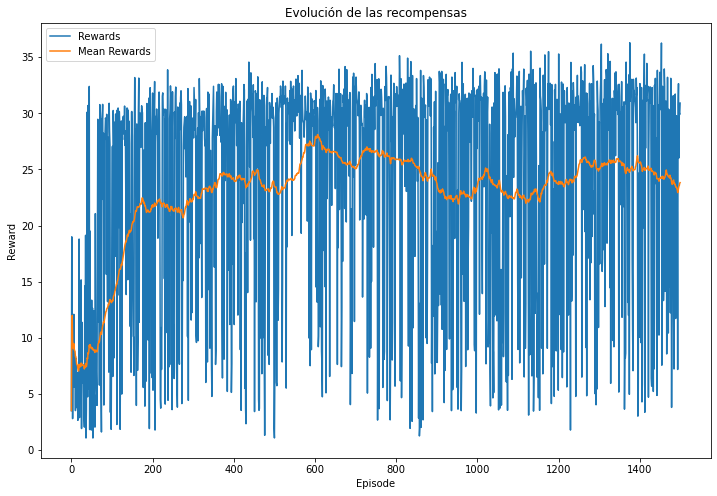

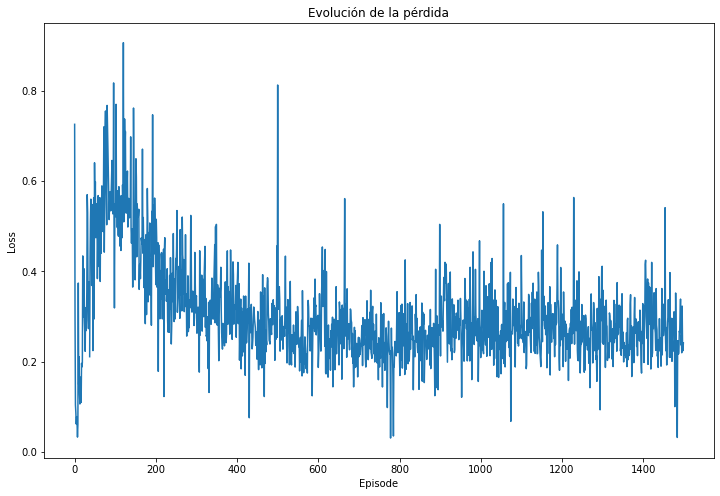

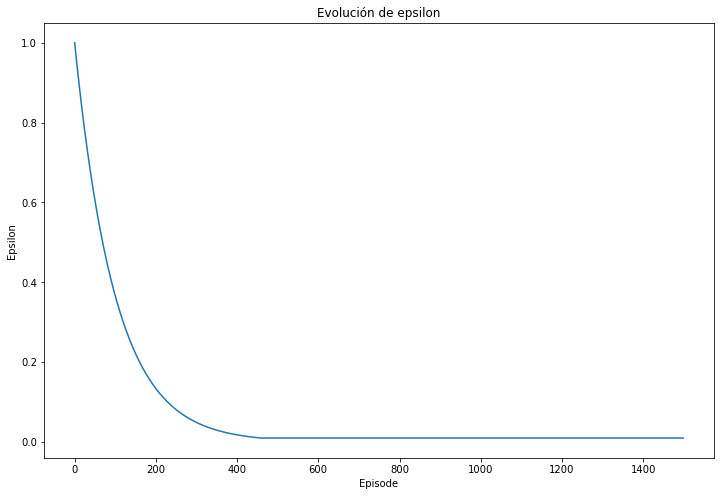

In [14]:
agent_dqn.plot_rewards()
agent_dqn.plot_loss()
agent_dqn.plot_epsilon()

Obs inicial:


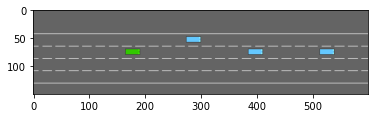


Acción: LANE_RIGHT -> recommpensa: 0.8444444444444444
Nuevo estado:


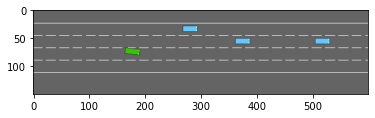


Acción: FASTER -> recommpensa: 0.9549926798276257
Nuevo estado:


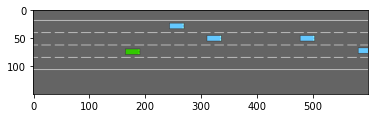


Acción: LANE_RIGHT -> recommpensa: 0.9961062948355148
Nuevo estado:


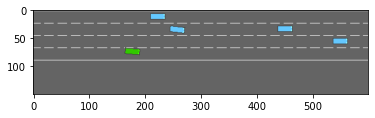


Acción: FASTER -> recommpensa: 0.9993346115982865
Nuevo estado:


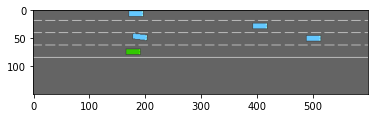


Acción: FASTER -> recommpensa: 0.9998862929506904
Nuevo estado:


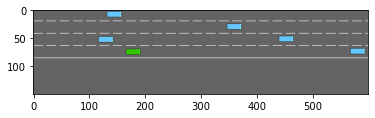


Acción: FASTER -> recommpensa: 0.9999805688030788
Nuevo estado:


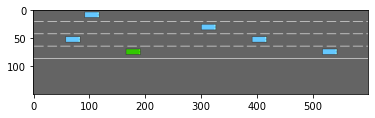


Acción: FASTER -> recommpensa: 0.9999966794370615
Nuevo estado:


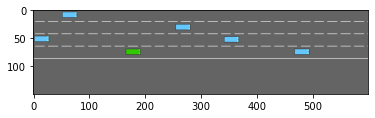


Acción: FASTER -> recommpensa: 0.9999994325548616
Nuevo estado:


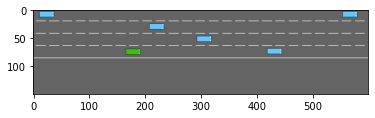


Acción: FASTER -> recommpensa: 0.9999999030303021
Nuevo estado:


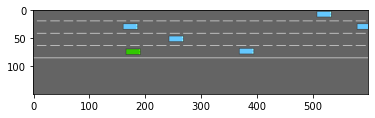


Acción: FASTER -> recommpensa: 0.9999999834290195
Nuevo estado:


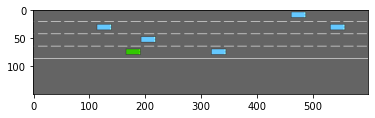


Acción: FASTER -> recommpensa: 0.9999999971682144
Nuevo estado:


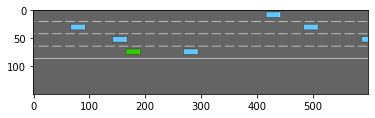


Acción: SLOWER -> recommpensa: 0.8894517641329
Nuevo estado:


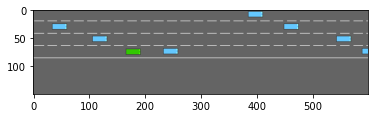


Acción: SLOWER -> recommpensa: 0.7600121363652744
Nuevo estado:


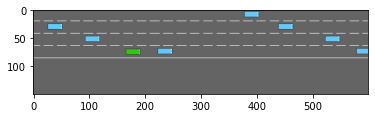


Acción: LANE_LEFT -> recommpensa: 0.7156702046631781
Nuevo estado:


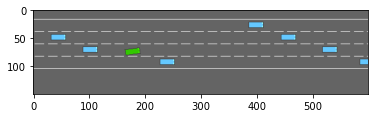


Acción: LANE_LEFT -> recommpensa: 0.689667984337497
Nuevo estado:


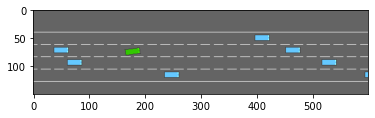


Acción: FASTER -> recommpensa: 0.7995702625178881
Nuevo estado:


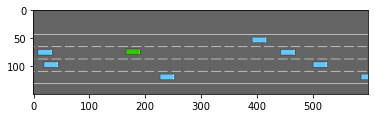


Acción: LANE_LEFT -> recommpensa: 0.796129046595304
Nuevo estado:


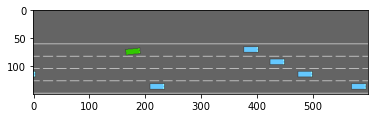


Acción: LANE_LEFT -> recommpensa: 0.7993384996063515
Nuevo estado:


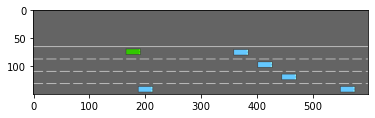


Acción: LANE_LEFT -> recommpensa: 0.7998869573655251
Nuevo estado:


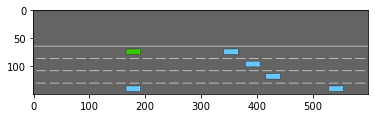


Acción: LANE_LEFT -> recommpensa: 0.7999806823437572
Nuevo estado:


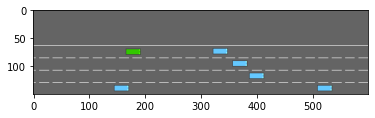


Acción: LANE_LEFT -> recommpensa: 0.7999966988398276
Nuevo estado:


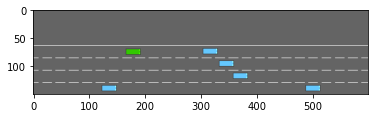


Acción: LANE_LEFT -> recommpensa: 0.7999994358705659
Nuevo estado:


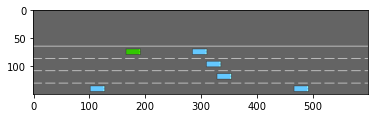


Acción: LANE_RIGHT -> recommpensa: 0.8222221258191391
Nuevo estado:


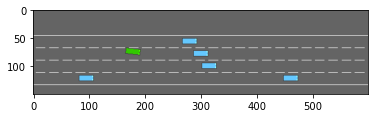


Acción: LANE_RIGHT -> recommpensa: 0.8444444279702918
Nuevo estado:


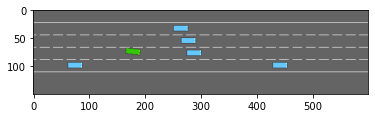


Acción: LANE_RIGHT -> recommpensa: 0.8666666638514279
Nuevo estado:


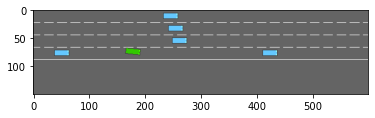


Acción: FASTER -> recommpensa: 0.9772149015687569
Nuevo estado:


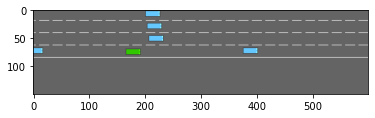


Acción: IDLE -> recommpensa: 0.996106294753302
Nuevo estado:


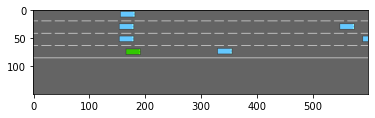


Acción: SLOWER -> recommpensa: 0.888786376201056
Nuevo estado:


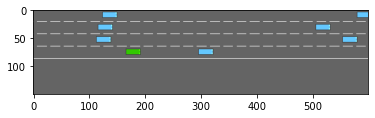


Acción: IDLE -> recommpensa: 0.8704466647794414
Nuevo estado:


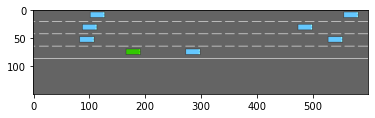


Acción: LANE_LEFT -> recommpensa: 0.8450904016488267
Nuevo estado:


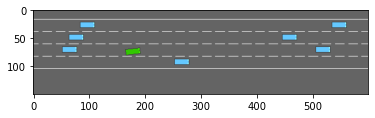


Acción: LANE_LEFT -> recommpensa: 0.8223326087085231
Nuevo estado:


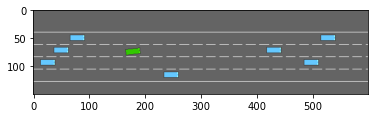


Acción: LANE_LEFT -> recommpensa: 0.8000188637517706
Nuevo estado:


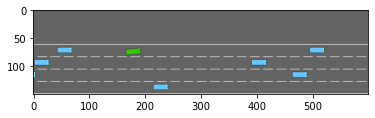


Acción: LANE_LEFT -> recommpensa: 0.8000032235932384
Nuevo estado:


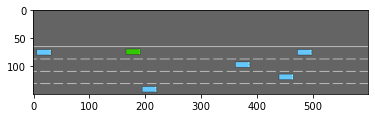


Acción: LANE_LEFT -> recommpensa: 0.8000005508741577
Nuevo estado:


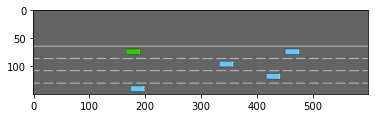


Acción: LANE_LEFT -> recommpensa: 0.8000000941379124
Nuevo estado:


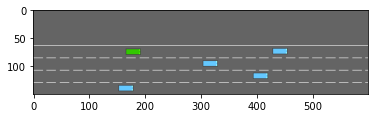


Acción: LANE_LEFT -> recommpensa: 0.8000000160870616
Nuevo estado:


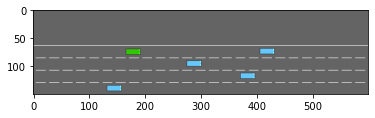


Acción: LANE_LEFT -> recommpensa: 0.8000000027490896
Nuevo estado:


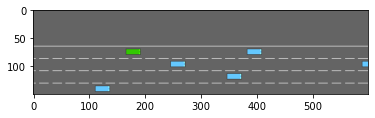


Acción: LANE_LEFT -> recommpensa: 0.800000000469787
Nuevo estado:


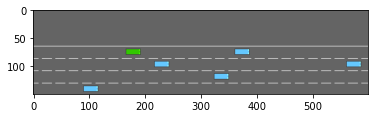


Acción: LANE_LEFT -> recommpensa: 0.800000000080281
Nuevo estado:


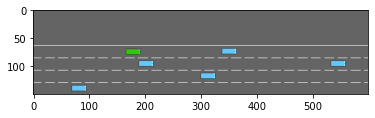


Acción: LANE_LEFT -> recommpensa: 0.8000000000137191
Nuevo estado:


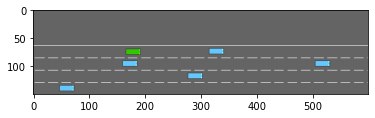

Episodio terminado después de 40 pasos y la recompensa fue 34.57777777777495


In [16]:
# Carga del modelo entrenado
modelo = torch.load("DQN.pth")['state_dic']
dqn.load_state_dict(modelo)

obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial:")
plt.imshow(env.render(mode="rgb_array"))
plt.show()
# print(obs)

while not done:
    # Obtener la acción y la ejecutamos
    action = dqn.get_action(obs, 0)
    new_obs, reward, done, info = env.step(action)
    
    # Imprimimos el paso
    print("\nAcción: {} -> recommpensa: {}".format(env.action_type.actions[action], reward))
    print("Nuevo estado:")
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
    env.close()
#     print(new_obs)
    
    t += 1
    total_reward += reward
    obs = new_obs
    
print("Episodio terminado después de {} pasos y la recompensa fue {}".format(t, total_reward))